# Decision Trees and Random Forests

1. [The Tasks](#tt) <br>
2. [Loading our Data and Libraries](#ld) <br>
3. [Decision Tree](#dt) <br>
4. [Random Forest](#rf) <br>
5. [Tuned Models](#tm) <br>

***

## The Tasks
<a id="tt" > 

For the decision tree model - using the high-level OverFeat features

- Split the train set into a (smaller) train and validation sets with respectively 3,200 and 800 points.
- Tune the depth parameter using grid search and plot the validation curve as described. Write your observations.
- Find the depth with the best validation accuracy and print it.  


For the random forest model - using the high-level OverFeat features

- Try different sizes of ensemble.
- Print their accuracy on the validation set.


For both models

- You might want to use PCA as a preprocessing step. In any case, justify your choice.
- Fit the tuned estimators on the entire train set with 4,000 data points. Evaluate and print the test accuracy.

***

## Loading/Preparing our Data and Libraries
<a id="ld" > 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
sns.set()
%matplotlib inline

In [2]:
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
print('Our data countains {}'.format(cifar4.keys()))

Our data countains dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [3]:
X_of = cifar4['overfeat']
y = cifar4['labels']
names = cifar4['names']

print('There are {:,} rows '.format(X_of.shape[0]) + 'and {} columns in our X dataset'.format(X_of.shape[1]))
print('There are {:,} rows in our y dataset '.format(y.shape[0]))

print('X has datatype:', X_of.dtype)
print('y has datatype:', y.dtype)

# We split our data and make sure that the sets have the same proportion of datapoints in each class by setting stratify=y
X_tr, X_te, y_tr, y_te = train_test_split(X_of, y, test_size=1000, random_state=0, stratify=y)
# Further splitting the test set into a test- and validation set
X_tr_2, X_val, y_tr_2, y_val = train_test_split(X_tr, y_tr, test_size=800, random_state=0, stratify=y_tr)

There are 5,000 rows and 4096 columns in our X dataset
There are 5,000 rows in our y dataset 
X has datatype: float32
y has datatype: int64


***

## Decision Tree
<a id="dt" > 

In [4]:
# We use pca as preproccessing and set it to 200 in order to retain 90+% of the variance and prevent overfitting
pipe = Pipeline([('pca', PCA(n_components=200)),
                 ('tree', DecisionTreeClassifier())])

In [5]:
# We try different levels of depth
n_depths = np.arange(1, 20)
#criterion = ('gini','entropy')
#n_components =  np.arange(100, 1000, 100)

grid = ParameterGrid({'tree__max_depth': n_depths,
#                     'tree__criterion': criterion,
#                    'pca__n_components': n_components
                     })

print ('There are {} possible combinations'.format(len(grid)))

There are 19 possible combinations


In [6]:
tree_score = []

# Grid search
for params_dict in grid:
    pipe.set_params(**params_dict)
    pipe.fit(X_tr_2, y_tr_2)
    params_dict['train accuracy'] = pipe.score(X_tr_2, y_tr_2)
    tree_score.append(params_dict)
    params_dict['validation accuracy'] = pipe.score(X_val, y_val)
    tree_score.append(params_dict)

In [7]:
tree_df = pd.DataFrame(tree_score)
tree_df.sort_values(by='validation accuracy', ascending=False).head()

,train accuracy,tree__max_depth,validation accuracy
12,0.804063,7,0.65000
13,0.804063,7,0.65000
6,0.662500,4,0.64875
7,0.662500,4,0.64875
8,0.697500,5,0.64875


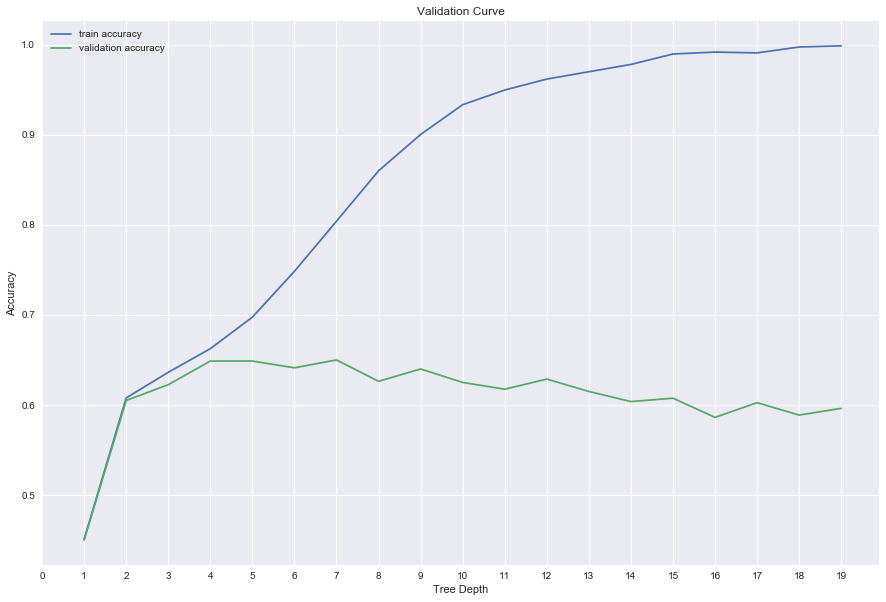

In [8]:
tree_df.plot(x='tree__max_depth', figsize=(15, 10) )
plt.title('Validation Curve')
plt.xlabel('Tree Depth')
plt.xticks(range(20))
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After a depth of about 3-5, our model seems to overfit.

In [9]:
best_tr = tree_df['train accuracy'].idxmax()
print ('Our best accuracy on the train set is {} and was achieves with a depth of {}'
       .format(tree_df.loc[best_tr,'train accuracy'], tree_df.loc[best_tr,'tree__max_depth']))

Our best accuracy on the train set is 0.99875 and was achieves with a depth of 19


In [10]:
best_val = tree_df['validation accuracy'].idxmax()
print ('Our best accuracy on the validation set is {} and was achieves with a depth of {}'
       .format(tree_df.loc[best_val,'validation accuracy'], tree_df.loc[best_val,'tree__max_depth']))

Our best accuracy on the validation set is 0.65 and was achieves with a depth of 7


***

## Random Forest
<a id="rf" > 

In [11]:
# We don't use PCA since random forrests are not that prone to overfitting
pipe = Pipeline([('pca', None),
                 ('forest', RandomForestClassifier(n_jobs=-1))])

In [12]:
# We try different numbers of estimators 
estimators = [1000, 1500, 2000]

grid = ParameterGrid({'forest__n_estimators': estimators,
                     })
print ('There are {} possible combinations'.format(len(grid)))

There are 3 possible combinations


In [13]:
val_forrest_scores = []

for params_dict in grid:
    pipe.set_params(**params_dict)
    pipe.fit(X_tr_2, y_tr_2)
    params_dict['accuracy'] = pipe.score(X_val, y_val)
    val_forrest_scores.append(params_dict)

In [14]:
# Top validation-scores
forest_df = pd.DataFrame(val_forrest_scores)
forest_df.sort_values(by='accuracy', ascending=False).head()

,accuracy,forest__n_estimators
0,0.79875,1000
1,0.79875,1500
2,0.79250,2000


In [15]:
best_forrest = forest_df['accuracy'].idxmax()
print ('Our best accuracy in the train set is {} and was achieves with {} estimators'
       .format(forest_df.loc[best_forrest, 'accuracy'], forest_df.loc[best_forrest, 'forest__n_estimators']))

Our best accuracy in the train set is 0.79875 and was achieves with 1000 estimators


***

## Tuned Models
<a id="tm" > 

In [16]:
# Tuned Tree
tree = DecisionTreeClassifier(max_depth= tree_df.loc[best_val,'tree__max_depth'])
pca = PCA(n_components=200)
pipe = Pipeline([('pca', pca),
                 ('tree', tree)])

pipe.fit(X_tr, y_tr)
acc_tree_tuned = pipe.score(X_te, y_te)
print ('Decision tree accuracy on the test set: {:.3f}'.format(acc_tree_tuned))

Decision tree accuracy on the test set: 0.648


In [17]:
# Tuned Forrest
forest = RandomForestClassifier(n_estimators = forest_df.loc[best_forrest,'forest__n_estimators'], n_jobs=-1)
pipe = Pipeline([('pca', None),
                 ('forest', forest)])

pipe.fit(X_tr, y_tr)
acc_forest_tuned = pipe.score(X_te, y_te)
print ('Random forest accuracy on the test set: {:.3f}'.format(acc_forest_tuned))

Random forest accuracy on the test set: 0.794
